<a href="https://colab.research.google.com/github/DonCappaccinno/Data-Science/blob/main/BANK_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance


In [14]:

# 2. Load Datasets
pre_covid_path = "/content/Pre Covid Housing.csv"
post_covid_path = "/content/post covid data.csv"
pre_covid_raw = pd.read_csv(pre_covid_path)
post_covid_raw = pd.read_csv(post_covid_path)


In [15]:
# 3. Standardize and Rename Columns
pre_covid_rename = {
    'Price': 'price',
    'Date': 'date',
    'PostCode': 'postcode',
    'Property Type': 'property_type',
    'Tenure': 'tenure',
    'Region': 'region'
}
post_covid_rename = {
    'price': 'price',
    'Date': 'date',
    'PostCode': 'postcode',
    'Property Type': 'property_type',
    'Tenure': 'tenure',
    'Region': 'region'
}
pre_covid = pre_covid_raw[list(pre_covid_rename.keys())].rename(columns=pre_covid_rename)
post_covid = post_covid_raw[list(post_covid_rename.keys())].rename(columns=post_covid_rename)


In [16]:
# 4. Clean Dates and Drop Nulls
pre_covid['date'] = pd.to_datetime(pre_covid['date'], errors='coerce')
post_covid['date'] = pd.to_datetime(post_covid['date'], errors='coerce')
pre_covid.dropna(subset=['price', 'date', 'region'], inplace=True)
post_covid.dropna(subset=['price', 'date', 'region'], inplace=True)


In [17]:
# 5. Filter Selected Regions
selected_regions = ['GREATER MANCHESTER', 'CENTRAL BEDFORDSHIRE', 'GREATER LONDON']
pre_filtered = pre_covid[pre_covid['region'].isin(selected_regions)]
post_filtered = post_covid[post_covid['region'].isin(selected_regions)]

# 6. Summary Table: Average Price Comparison
pre_grouped = pre_filtered.groupby('region')['price'].mean().reset_index(name='pre_covid_avg_price')
post_grouped = post_filtered.groupby('region')['price'].mean().reset_index(name='post_covid_avg_price')
comparison = pd.merge(pre_grouped, post_grouped, on='region', how='outer')
comparison['price_change'] = comparison['post_covid_avg_price'] - comparison['pre_covid_avg_price']
print("\nAverage Price Comparison by Region:")
print(comparison.sort_values(by='price_change', ascending=False))



Average Price Comparison by Region:
                 region  pre_covid_avg_price  post_covid_avg_price  \
2    GREATER MANCHESTER         2.082650e+05         273430.175888   
1        GREATER LONDON         1.452752e+06         843834.981198   
0  CENTRAL BEDFORDSHIRE                  NaN         558537.574813   

    price_change  
2   65165.223507  
1 -608916.559342  
0            NaN  


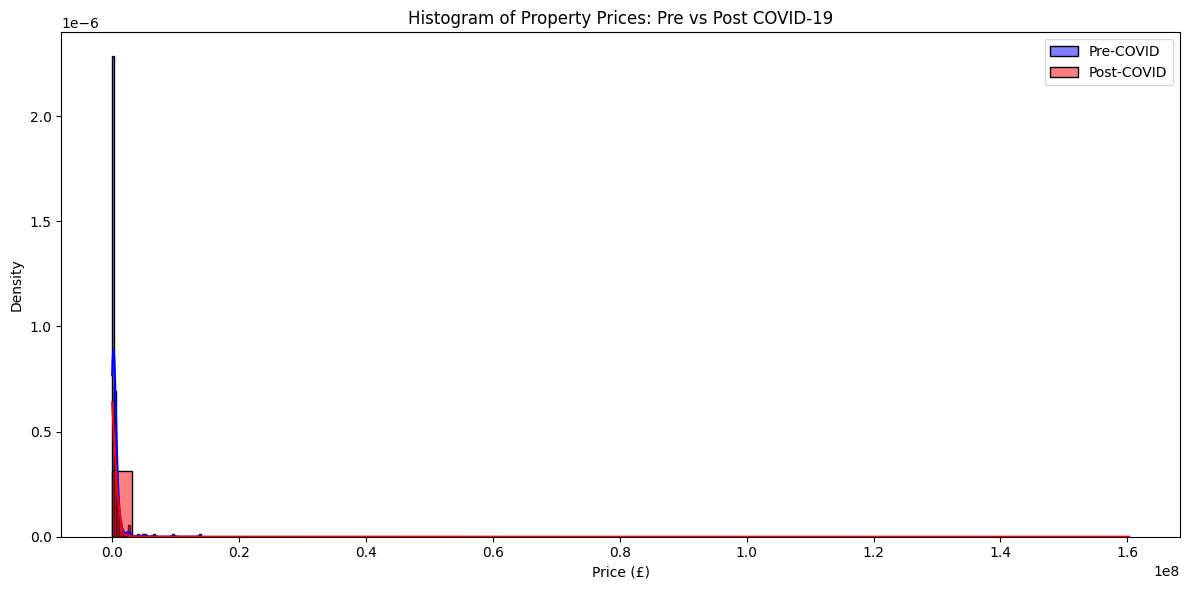

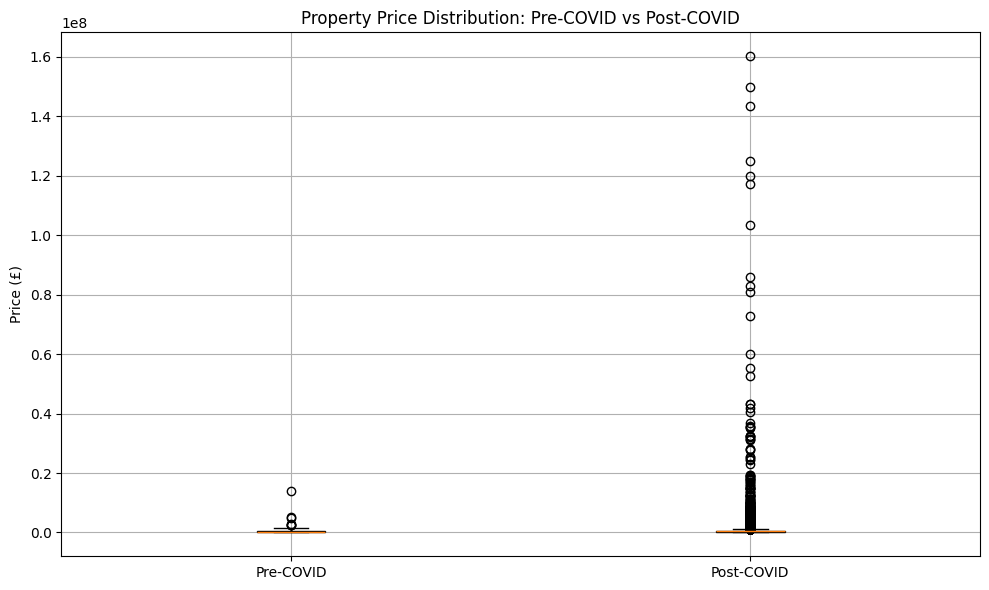

In [31]:
# 7. Histogram: Price Distributions Pre vs Post COVID
plt.figure(figsize=(12, 6))
sns.histplot(pre_covid['price'], label='Pre-COVID', color='blue', kde=True, bins=50, stat='density', alpha=0.5)
sns.histplot(post_covid['price'], label='Post-COVID', color='red', kde=True, bins=50, stat='density', alpha=0.5)
plt.title('Histogram of Property Prices: Pre vs Post COVID-19')
plt.xlabel('Price (£)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# 8. Boxplot
plt.figure(figsize=(10, 6))
data = [pre_filtered['price'], post_filtered['price']]
labels = ['Pre-COVID', 'Post-COVID']
plt.boxplot(data, tick_labels=labels, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Property Price Distribution: Pre-COVID vs Post-COVID")
plt.ylabel("Price (£)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# 9. Preview Cleaned Data
print("\nPre-COVID Sample:\n", pre_filtered.head())
print("\nPost-COVID Sample:\n", post_filtered.head())

# 10. Combine Datasets for Modeling
df = pd.concat([pre_filtered, post_filtered], ignore_index=True)

# 11. Preprocessing
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['price', 'postcode', 'date'])
df = df[df['price'] > 10000]
df = df[df['price'] < df['price'].quantile(0.99)]



Pre-COVID Sample:
     price       date postcode property_type tenure              region
0  770000 2018-09-25  SK7 1AR             D      F  GREATER MANCHESTER
1  253500 2018-09-24   M6 8GQ             D      F  GREATER MANCHESTER
2  231950 2018-09-28  WA3 2UE             D      F  GREATER MANCHESTER
3  112500 2018-08-29  OL6 6RJ             S      F  GREATER MANCHESTER
4  184995 2018-06-15  M46 0TW             S      F  GREATER MANCHESTER

Post-COVID Sample:
     price       date  postcode property_type tenure                region
0  407400 2022-04-28   LU7 3FZ             S      F  CENTRAL BEDFORDSHIRE
1  357000 2022-05-27   LU7 3QS             S      F  CENTRAL BEDFORDSHIRE
2  372950 2022-04-28   LU5 6TD             S      F  CENTRAL BEDFORDSHIRE
3  570000 2022-05-31  SG18 9RF             D      F  CENTRAL BEDFORDSHIRE
4  570000 2022-05-27   LU7 3QS             D      F  CENTRAL BEDFORDSHIRE


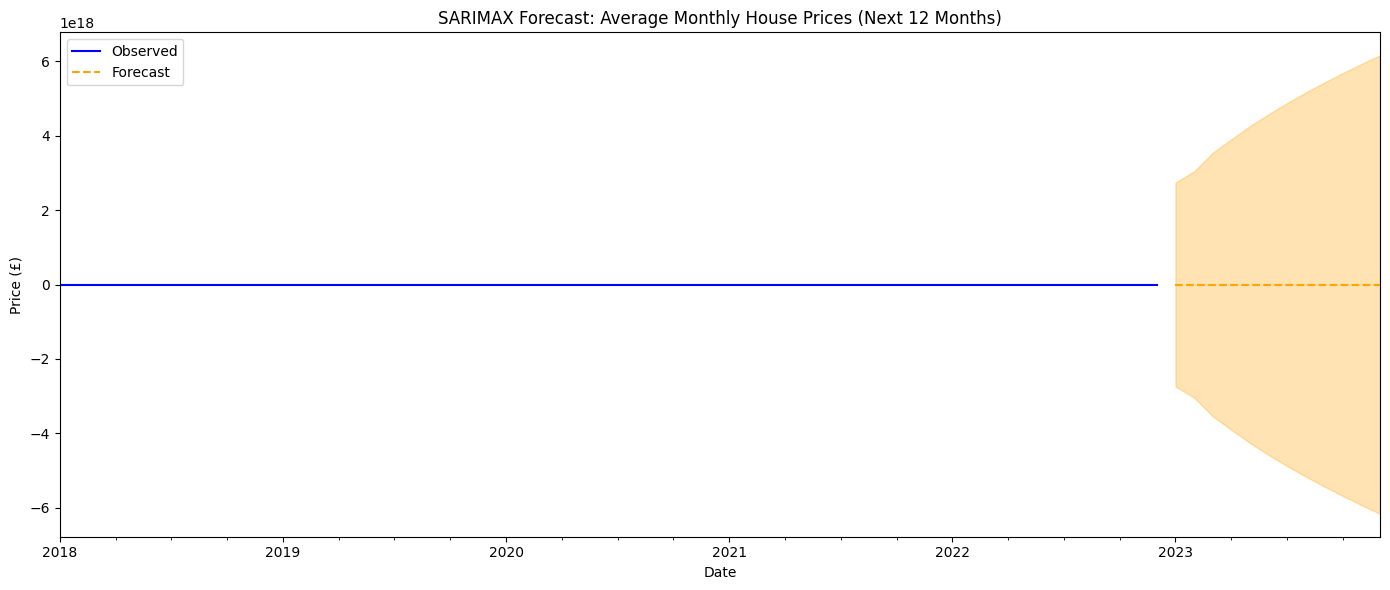

Forecasted Average Monthly Prices:
               Date  Forecasted Price (£)
2023-01-01  2023-01             578973.95
2023-02-01  2023-02             452445.16
2023-03-01  2023-03             480926.97
2023-04-01  2023-04             500281.67
2023-05-01  2023-05             528608.76
2023-06-01  2023-06             569957.37
2023-07-01  2023-07             630648.20
2023-08-01  2023-08             587971.27
2023-09-01  2023-09             574638.48
2023-10-01  2023-10             571562.71
2023-11-01  2023-11             593408.17
2023-12-01  2023-12             577905.41


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 1. Prepare monthly time series with frequency
monthly_avg = df.copy()
monthly_avg['year_month'] = df['date'].dt.to_period('M').astype(str)
monthly_avg = monthly_avg.groupby('year_month')['price'].mean().reset_index()
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'])
monthly_avg = monthly_avg.set_index('year_month')

# Create a full date range to handle missing months
full_date_range = pd.date_range(start=monthly_avg.index.min(),
                                end=monthly_avg.index.max(),
                                freq='MS')

# Reindex the DataFrame to include all months in the range
monthly_avg = monthly_avg.reindex(full_date_range)


# Fill any missing months if necessary
monthly_avg['price'] = monthly_avg['price'].interpolate(method='linear')

# 2. Fit SARIMA model without warnings
model = SARIMAX(monthly_avg['price'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# 3. Forecast next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
conf_int = forecast.conf_int()

# Create forecast index with frequency
forecast_index = pd.date_range(start=monthly_avg.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# 4. Plot forecast
plt.figure(figsize=(14, 6))
monthly_avg['price'].plot(label='Observed', color='blue')
forecast_series.plot(label='Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.3)
plt.title("SARIMAX Forecast: Average Monthly House Prices (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Price (£)")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Print Forecast Table
forecast_df = pd.DataFrame({
    "Date": forecast_index.strftime('%Y-%m'),
    "Forecasted Price (£)": forecast_series.round(2)
})
print("Forecasted Average Monthly Prices:")
print(forecast_df)

In [24]:
# 12. Feature Engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['during_covid'] = (df['date'] >= '2020-03-01').astype(int)
df['postcode_area'] = df['postcode'].str.extract(r'^([A-Z]{1,2})')[0]

df['region_avg_price'] = df.groupby('region')['price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['price_diff_pct'] = df.groupby('postcode_area')['price'].pct_change().fillna(0)

postcode_mean = df.groupby('postcode_area')['price'].mean()
df['postcode_area_encoded'] = df['postcode_area'].map(postcode_mean)
region_mean = df.groupby('region')['price'].mean()
df['region_encoded'] = df['region'].map(region_mean)

df = pd.get_dummies(df, columns=['property_type', 'tenure'], drop_first=True)
df = df.drop(columns=['postcode_area', 'region'])


In [32]:
# 13. Log-transform Target
df['log_price'] = np.log1p(df['price'])

# 14. Train/Test Split
X = df.drop(columns=['price', 'log_price', 'date', 'postcode'])
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 15. Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.1, n_estimators=100)
xgb_model.fit(X_train, y_train)

# 16. Predict & Evaluate
preds_log = xgb_model.predict(X_test)
preds = np.expm1(preds_log)
y_test_actual = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
r2 = r2_score(y_test_actual, preds)
mean_price = y_test_actual.mean()
rmse_pct = (rmse / mean_price) * 100

print("PREDICTIVE MODEL PERFORMANCE")
print("=" * 50)
print(f"Model Accuracy (R² Score): {r2 * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): £{rmse:,.2f}")
print(f"Mean Future Price: £{mean_price:,.2f}")
print(f"RMSE as % of Mean Price: {rmse_pct:.2f}%")
print("=" * 50)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Log-transform Target (already done)
df['log_price'] = np.log1p(df['price'])

# 2. Drop unnecessary or high-cardinality columns
X = df.drop(columns=['price', 'log_price', 'date', 'postcode'])  # drop postcode unless encoded properly
y = df['log_price']

# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Improve model with optimized hyperparameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,               # increase model capacity
    learning_rate=0.05,        # smaller learning rate for precision
    n_estimators=300,          # more trees for accuracy
    subsample=0.8,             # prevent overfitting
    colsample_bytree=0.8,
    gamma=0,                   # regularization
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# 5. Train the model
xgb_model.fit(X_train, y_train)

# 6. Predict
preds_log = xgb_model.predict(X_test)
preds = np.expm1(preds_log)
y_test_actual = np.expm1(y_test)

# 7. Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
r2 = r2_score(y_test_actual, preds)
mean_price = y_test_actual.mean()
rmse_pct = (rmse / mean_price) * 100

# 8. Output
print("PREDICTIVE MODEL PERFORMANCE")
print("=" * 50)
print(f"Model Accuracy (R² Score): {r2 * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): £{rmse:,.2f}")
print(f"Mean Future Price: £{mean_price:,.2f}")
print(f"RMSE as % of Mean Price: {rmse_pct:.2f}%")
print("=" * 50)


PREDICTIVE MODEL PERFORMANCE
Model Accuracy (R² Score): 78.32%
Root Mean Squared Error (RMSE): £227,330.02
Mean Future Price: £552,985.69
RMSE as % of Mean Price: 41.11%
PREDICTIVE MODEL PERFORMANCE
Model Accuracy (R² Score): 79.73%
Root Mean Squared Error (RMSE): £219,789.53
Mean Future Price: £552,985.69
RMSE as % of Mean Price: 39.75%


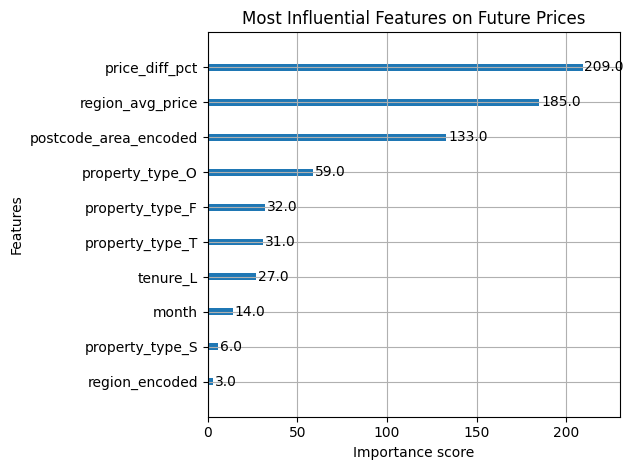

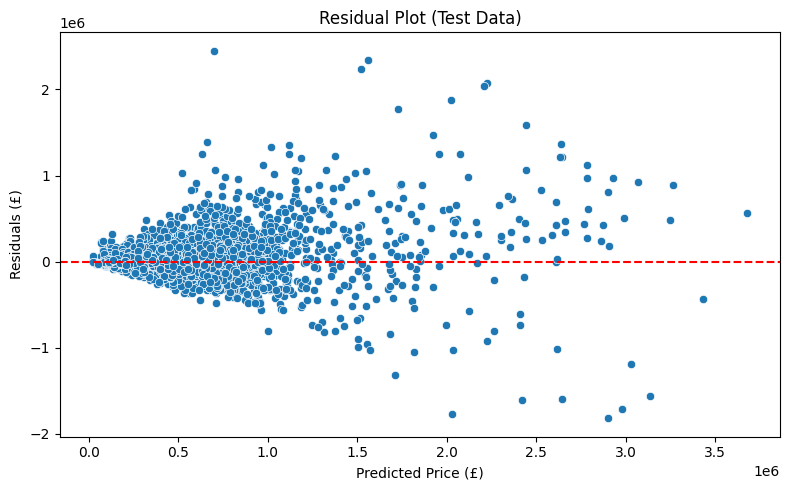

Linear Regression RMSE: £566,756.70


In [26]:
# 17. Feature Importance
plot_importance(xgb_model, max_num_features=15)
plt.title("Most Influential Features on Future Prices")
plt.tight_layout()
plt.show()

# 18. Residual Plot
residuals = y_test_actual - preds
plt.figure(figsize=(8, 5))
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (£)")
plt.ylabel("Residuals (£)")
plt.title("Residual Plot (Test Data)")
plt.tight_layout()
plt.show()

# 19. Baseline: Linear Regression Comparison
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds_log = lr.predict(X_test)
lr_preds = np.expm1(lr_preds_log)
lr_rmse = np.sqrt(mean_squared_error(y_test_actual, lr_preds))
print(f"Linear Regression RMSE: £{lr_rmse:,.2f}")
